In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# Import data using datetime and set index to datetime
df = pd.read_csv(r'D:\aa\working_results\Book3.CSV',
                                parse_dates=['Date'],
                                index_col=['Date'])

df.head()

,pm25,pm10,no2,so2,co,o3
Date,,,,,,
2017-10-17 10:00:00,110.75,234.67,82.22,101.55,1.06,27.12
2017-10-17 11:00:00,165.34,536.91,49.09,130.76,0.98,87.85
2017-10-17 12:00:00,130.91,555.58,43.34,129.64,0.53,79.69
2017-10-17 13:00:00,126.39,556.05,32.97,103.30,0.40,78.19
2017-10-17 14:00:00,131.90,504.41,42.27,94.55,0.17,72.72


<AxesSubplot:>

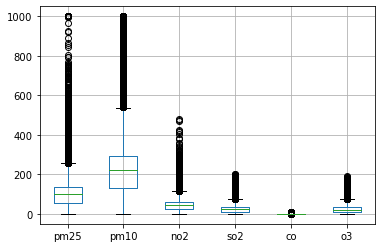

In [5]:
#Box plot
#pd.options.display.mpl_style = False
df.boxplot()

In [6]:
from sklearn.preprocessing import LabelEncoder

# Encode non categorical values
values = df.values
encoder = LabelEncoder()
values[:,11] = encoder.fit_transform(values[:,11])
values = values.astype('float32')
values[:,11]

IndexError: index 11 is out of bounds for axis 1 with size 6

In [7]:
#Normalising data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_dataset = scaler.fit_transform(values)

In [8]:
#Creating a window for previous data
def to_supervised(train):
  window_size = 4
  X = []
  Y = []
  for i in range(window_size, len(train)):
    X.append(train[i-window_size:i,:])
    Y.append(train[i,0:1])
    
  return X,Y

In [9]:
X, Y = to_supervised(scaled_dataset)
X = np.array(X)
Y = np.array(Y)
print('Y' ,Y.shape)
print('X' ,X.shape)

Y (45263, 1)
X (45263, 4, 6)


In [10]:
#Splitting the dataset 365*.2=73 and 365-73=292
n_train = 3848
X_train, X_test = X[n_train:,] , X[:n_train,]
print('X_train' ,X_train.shape)
print('X_test' ,X_test.shape)

Y_train, Y_test = Y[n_train:,] , Y[:n_train,]
print('Y_train' ,Y_train.shape)
print('Y_test' ,Y_test.shape)


X_train (41415, 4, 6)
X_test (3848, 4, 6)
Y_train (41415, 1)
Y_test (3848, 1)


In [11]:

#Importing LSTM model
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout,LSTM
import tensorflow as tf
model = Sequential()

model.add(LSTM(units = 100, return_sequences = True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(units = 100, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 100))
model.add(Dropout(0.2))

model.add(Dense(units = 1))

#model.compile(optimizer = 'adam', loss = 'mean_squared_error')     
opt = keras.optimizers.Adam(learning_rate=0.1)
model.compile(loss='mean_squared_error', optimizer=opt)

In [12]:
def call(c):
    history = model.fit(X_train, Y_train, epochs=c,
                    batch_size=32, validation_data=(X_test,Y_test),
                    verbose=2, shuffle=False)
        # plot train and validation loss
    from matplotlib import pyplot
    pyplot.plot(history.history['loss'])
    pyplot.plot(history.history['val_loss'])
    pyplot.title('model train vs validation loss')
    pyplot.ylabel('loss')
    pyplot.xlabel('epoch')
    pyplot.legend(['train', 'validation'], loc='upper right')
    pyplot.show()
    Y_pred = model.predict(X_test)

    from sklearn.metrics import mean_squared_error
    mse = mean_squared_error(Y_test, Y_pred)
    print(mse)

    rmse = np.sqrt(mse)
    print(rmse)
    
    #fn
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    mape = mean_absolute_percentage_error(Y_test, Y_pred)
    print('MAPE', mape)

Epoch 1/50
1295/1295 - 26s - loss: 0.0415 - val_loss: 0.0389 - 26s/epoch - 20ms/step
Epoch 2/50
1295/1295 - 20s - loss: 0.0303 - val_loss: 0.0553 - 20s/epoch - 16ms/step
Epoch 3/50
1295/1295 - 18s - loss: 0.0293 - val_loss: 0.0503 - 18s/epoch - 14ms/step
Epoch 4/50
1295/1295 - 18s - loss: 0.0303 - val_loss: 0.0459 - 18s/epoch - 14ms/step
Epoch 5/50
1295/1295 - 18s - loss: 0.0316 - val_loss: 0.0416 - 18s/epoch - 14ms/step
Epoch 6/50
1295/1295 - 19s - loss: 0.0317 - val_loss: 0.0296 - 19s/epoch - 14ms/step
Epoch 7/50
1295/1295 - 18s - loss: 0.0304 - val_loss: 0.0182 - 18s/epoch - 14ms/step
Epoch 8/50
1295/1295 - 20s - loss: 0.0305 - val_loss: 0.0209 - 20s/epoch - 15ms/step
Epoch 9/50
1295/1295 - 20s - loss: 0.0265 - val_loss: 0.0436 - 20s/epoch - 15ms/step
Epoch 10/50
1295/1295 - 19s - loss: 0.0313 - val_loss: 0.0221 - 19s/epoch - 15ms/step
Epoch 11/50
1295/1295 - 20s - loss: 0.0285 - val_loss: 0.0264 - 20s/epoch - 15ms/step
Epoch 12/50
1295/1295 - 20s - loss: 0.0318 - val_loss: 0.0216 -

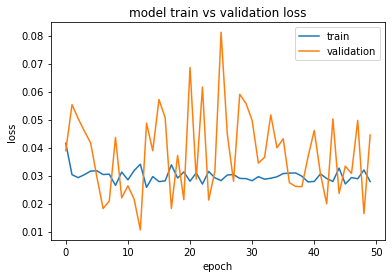

121/121 [==============================] - 2s 4ms/step
0.04447568818650712
0.21089259870016094
MAPE 118.41782605671054
Epoch 1/100
1295/1295 - 15s - loss: 0.0303 - val_loss: 0.0433 - 15s/epoch - 12ms/step
Epoch 2/100
1295/1295 - 15s - loss: 0.0301 - val_loss: 0.0351 - 15s/epoch - 11ms/step
Epoch 3/100
1295/1295 - 15s - loss: 0.0292 - val_loss: 0.0382 - 15s/epoch - 12ms/step
Epoch 4/100
1295/1295 - 15s - loss: 0.0300 - val_loss: 0.0298 - 15s/epoch - 12ms/step
Epoch 5/100
1295/1295 - 15s - loss: 0.0309 - val_loss: 0.0249 - 15s/epoch - 12ms/step
Epoch 6/100
1295/1295 - 15s - loss: 0.0282 - val_loss: 0.0355 - 15s/epoch - 12ms/step
Epoch 7/100
1295/1295 - 15s - loss: 0.0305 - val_loss: 0.0238 - 15s/epoch - 12ms/step
Epoch 8/100
1295/1295 - 15s - loss: 0.0303 - val_loss: 0.0232 - 15s/epoch - 12ms/step
Epoch 9/100
1295/1295 - 16s - loss: 0.0281 - val_loss: 0.0396 - 16s/epoch - 12ms/step
Epoch 10/100
1295/1295 - 17s - loss: 0.0312 - val_loss: 0.0260 - 17s/epoch - 13ms/step
Epoch 11/100
1295/12

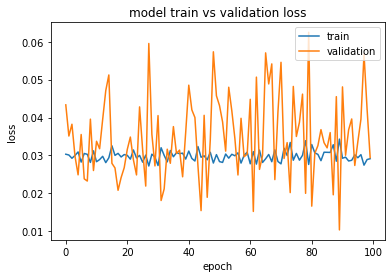

121/121 [==============================] - 0s 3ms/step
0.029415182290340482
0.17150854873836605
MAPE 83.78292331239494
Epoch 1/150
1295/1295 - 10s - loss: 0.0292 - val_loss: 0.0272 - 10s/epoch - 8ms/step
Epoch 2/150
1295/1295 - 10s - loss: 0.0288 - val_loss: 0.0745 - 10s/epoch - 8ms/step
Epoch 3/150
1295/1295 - 10s - loss: 0.0296 - val_loss: 0.0257 - 10s/epoch - 8ms/step
Epoch 4/150
1295/1295 - 10s - loss: 0.0280 - val_loss: 0.0608 - 10s/epoch - 8ms/step
Epoch 5/150
1295/1295 - 10s - loss: 0.0291 - val_loss: 0.0267 - 10s/epoch - 8ms/step
Epoch 6/150
1295/1295 - 10s - loss: 0.0305 - val_loss: 0.0320 - 10s/epoch - 8ms/step
Epoch 7/150
1295/1295 - 10s - loss: 0.0309 - val_loss: 0.0330 - 10s/epoch - 8ms/step
Epoch 8/150
1295/1295 - 10s - loss: 0.0282 - val_loss: 0.0450 - 10s/epoch - 8ms/step
Epoch 9/150
1295/1295 - 10s - loss: 0.0311 - val_loss: 0.0497 - 10s/epoch - 8ms/step
Epoch 10/150
1295/1295 - 10s - loss: 0.0284 - val_loss: 0.0244 - 10s/epoch - 8ms/step
Epoch 11/150
1295/1295 - 10s -

In [ ]:
l=[50,100,150,200,250]
for i in l:
    call(i)